# 基于RetinaFace的人脸检测

## 一、综述

随着深度学习技术的发展，现在人脸检测、识别任务都广泛应用深度学习模型，在精度上有了长足的进步。  
[InsightFace](https://github.com/deepinsight/insightface/tree/master/RetinaFace)是目前深度学习领域SOTA（最先进的，State Of The Art）的人脸分析项目，其中人脸检测（和校正）由RetinaFace实现。  

### 什么是检测？
![什么是检测](img/5.png "什么是检测")

### 神经网络如何做检测？
![如何做检测](img/6.png "如何做检测")

### 为什么要做人脸检测？

工业级的人脸识别需要包含4个步骤：  
   * 人脸检测  
   * 人脸矫正  
   * 姿态过滤  
   * 人脸识别  
   
![人脸识别的流程](img/3.png "人脸识别的流程")

人脸检测是人脸识别的第一步，这篇教程的目标就是基于RetinaFace预训练模型的人脸检测。  

## 二、环境

InsightFace是基于MXNet框架的，我们的环境使用Python 2.7版本。**请从Notebook Kernel菜单中切换Kernal到mxnet_python2环境。**  
RetinaFace是检测模型，随模型提供了NMS（非极大值抑制，Non Maximum Suppression）的实现。线下环境中需要安装Cython并执行make进行编译，MOOP线上环境的镜像中已经完成了这一步骤，可以直接导入RetinaFace进行检测。  
由于只需要模型前向推断，我们可以用CPU进行计算，对计算机硬件的需求相对比较低。  
RetinaFace的[Github页面](https://github.com/deepinsight/insightface/tree/master/RetinaFace)提供了预训练模型，线下环境可以下载并按照说明放置在项目目录中。MOOP环境已经完成了预训练模型的配置，选用的是RetinaFace-R50模型参数，官方发布的参数可以在WiderFace Hard测试集上取得90.4的mAP。  

In [1]:
import os
import sys
import random
import datetime
from multiprocessing import Process

import cv2
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline 

sys.path.append(os.path.join(os.path.abspath(''), 'RetinaFace'))
from retinaface import RetinaFace

/home/voyager/anaconda3/envs/mxnet_python2/lib/python2.7/site-packages/mxnet/numpy_op_signature.py:61: UserWarning: Some mxnet.numpy operator signatures may not be displayed consistently with their counterparts in the official NumPy package due to too-low Python version 2.7.15 | packaged by conda-forge | (default, Feb 26 2019, 02:46:43) 
[GCC 7.3.0]. Python >= 3.5 is required to make the signatures display correctly.
  .format(str(sys.version)))


数据的准备，我们已经在data/input下准备了图片：  

In [2]:
input_picure_path = os.path.join(os.path.abspath(''), 'data/input')

定义图片处理的Helper：  

In [3]:
def get_img_scale(img_shape, scales):
    target_size, max_size = scales
    
    img_size_min = np.min(img_shape[0:2])
    img_size_max = np.max(img_shape[0:2])
    
    img_scale = float(target_size) / float(img_size_min)
    
    if np.round(img_scale * img_size_max) > max_size:
        img_scale = float(max_size) / float(img_size_max)
        
    return img_scale

def draw_on_img(img, faces, landmarks=None):
    for i in range(faces.shape[0]):
        box = faces[i].astype(np.int)
        
        color = (0, 0, 255)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        
        if landmarks is not None:
            landmark5 = landmarks[i].astype(np.int)
            
            for l in range(landmark5.shape[0]):
                color = (0, 255, 0)
                cv2.circle(img, (landmark5[l][0], landmark5[l][1]), 1, color, 2)
                
    plt.imshow(img[..., ::-1])
    plt.show()

## 三、模型准备

接下来需要设置参数并初始化检测模型。  
要注意当gpu_id小于0的时候，MxNet会自动选用CPU进行计算。  
另外RetinaFace最后一个参数用于选择[Anchor](https://www.quora.com/What-does-an-anchor-mean-in-object-detection)的大小，会影响不同尺寸人脸检测的精度。  

In [4]:
# consts
score_threshold = 0.94
image_scales = [720, 1024]

# init detector - mxnet selects cpu if gpu_id < 0
gpu_id = -1

detector = RetinaFace('../../share/data/pro_face_recognition/model/R50', 0, gpu_id, 'net3')

[32, 16, 8] {'32': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (32, 16)}, '8': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (2, 1)}, '16': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (8, 4)}}
means [0. 0. 0.]
use_landmarks True
sym size: 9


## 四、检测

2.jpg: spent 0.934533 sec(s), detected 3 face(s)


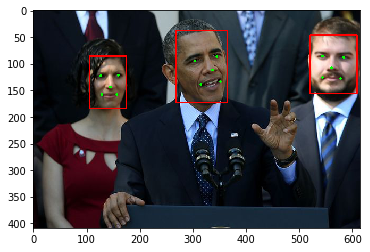

1.jpg: spent 0.824207 sec(s), detected 2 face(s)


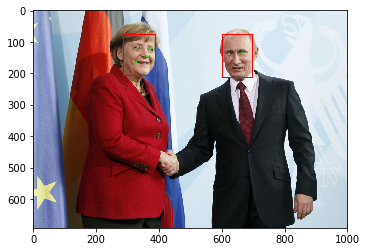

In [5]:
# list input pics
entries = os.listdir(input_picure_path)

for entry in entries:
    arr = entry.split('.')

    if len(arr) > 1 and arr[1] == 'jpg':
        # read image
        img_path = os.path.join(input_picure_path, entry)
        img = cv2.imread(img_path)

        img_scale = get_img_scale(img.shape, image_scales)
        
        start_time = datetime.datetime.now()
        
        faces, landmarks = detector.detect(
            img,
            score_threshold,
            scales=[img_scale],
            do_flip=False
        )
        
        end_time = datetime.datetime.now()
        time_diff = end_time - start_time
        
        print('{}: spent {} sec(s), detected {} face(s)'.format(
            entry,
            time_diff.total_seconds(),
            faces.shape[0]
        ))
        
        draw_on_img(img, faces, landmarks=landmarks)

## 五、课堂练习  
1. 在人脸检测中，我们得到了人脸框和五个关键点，它们的数据格式是怎样的呢？请在下方代码框内，编写程序打印输出它们。  
提示：修改检测这节代码中，Print函数输出的内容，对于Python不熟悉的同学，可以在线查看[Python Print文档](https://docs.python.org/zh-cn/3.7/library/functions.html#print)。  

2. 试着上传自己的照片并进行人脸检测吧！  
提示：我们的数据保存在data/input，需要利用jupyter notebook的文件浏览功能上传图片。  